# Twitter Sentiment Analysis

> Di project ini saya akan mencoba melakukan sentiment analysis menggunakan tweet-tweet yang berhubungan dengan kata `AlbertEinstein`. 

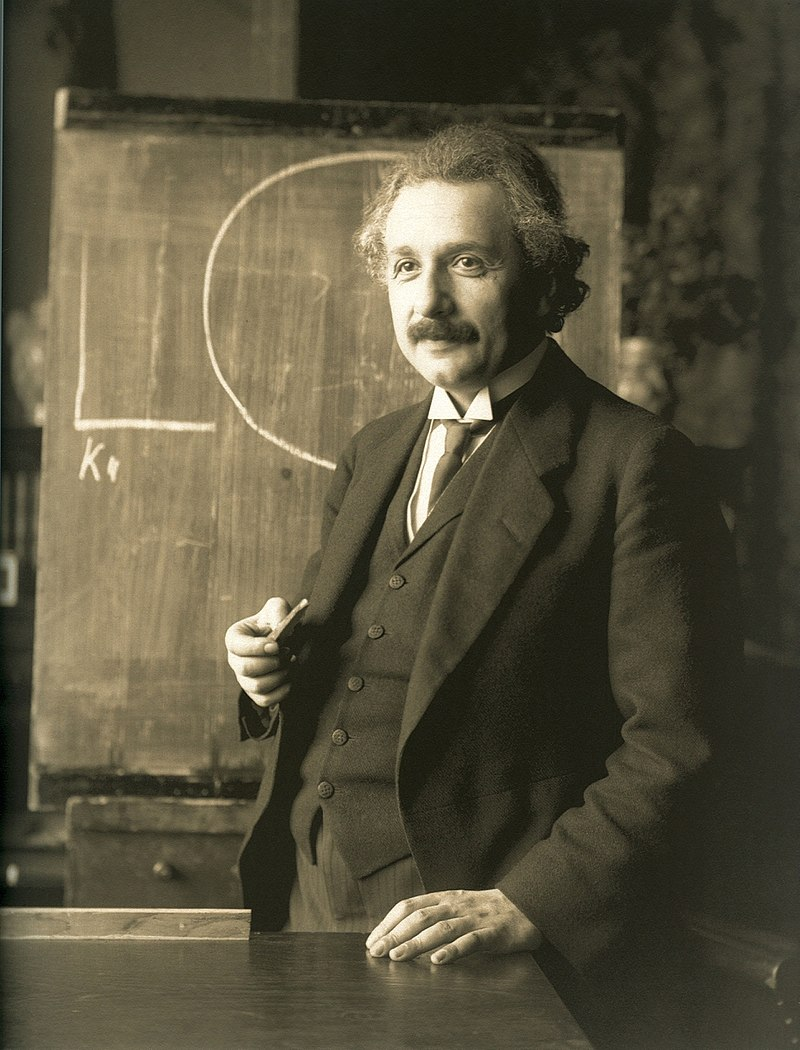

In [3]:
from IPython.display import Image

Image(filename='einstein.jpg', height = 200, width = 300) 

source : http://www.bhm.ch/de/news_04a.cfm?bid=4&jahr=2006

In [4]:
import tweepy
from twitter_key import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [5]:
sns.set_style('whitegrid')

In [6]:
auth = tweepy.OAuthHandler(API_key, API_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [7]:
tweets = api.user_timeline(screen_name = 'AlbertEinstein', count = 200, lang = 'en', tweet_mode = 'extended')

Saya memilih kata `AlbertEinstein` karena alasan personal, mengingat saya dulu kuliah fisika dan masuk ke peminatan fisika teori. Saya juga beruntung dapat belajar Relativitas umum saat kuliah, dimana itu adalah salah satu karya Einstein yang paling saya kagumi. 

In [8]:
for tweet in tweets[:5]:
    print(tweet['full_text'] + '\n')

The scientific mysteries that led to Einstein’s E=mc2 equation
https://t.co/IVzedGCwoM

Birthed in the first second after the Big Bang, primordial black holes could offer answers to astronomers’ outstanding questions ... if they exist. https://t.co/QaqXfVyWBB

#WednesdayWisdom: "In the past it never occurred to me that every casual remark of mine would be snatched up and recorded. Otherwise I would have crept further into my shell.” – Albert Einstein, 1953 https://t.co/4bB1Kq4YvG

Einstein credited his accomplishments to his unbridled curiosity. Here are just some of the benefits of questioning what's going on around you. https://t.co/Mj1TzRDYAw

@jerryjamesstone @Spooniverse Intelligence is relative 😎



In [9]:
df = pd.DataFrame([tweet['full_text'] for tweet in tweets], columns = ['Tweets'])

df.head()

,Tweets
0,The scientific mysteries that led to Einstein’...
1,Birthed in the first second after the Big Bang...
2,"#WednesdayWisdom: ""In the past it never occurr..."
3,Einstein credited his accomplishments to his u...
4,@jerryjamesstone @Spooniverse Intelligence is ...


In [10]:
def clean(txt):
    txt = re.sub('@[A-Za-z0–9]+', '', txt) #Menghilangkan mention
    txt = re.sub('https?:\/\/\S+', '', txt) # Menghilangkan Link
    txt = re.sub('RT[\s]+', '', txt) # Menghilangkan RT
    txt = re.sub('#', '', txt) #Menghilangkan HashTag
    txt = re.sub('[%s]' % re.escape(string.punctuation), '', txt)
    txt = re.sub(r'(\w)\1+', r'\1', txt)
    txt = str(txt).lower()
    return txt

df['Tweets'] = df['Tweets'].apply(clean)

In [11]:
df

,Tweets
0,the scientific mysteries that led to einstein’...
1,birthed in the first second after the big bang...
2,wednesdaywisdom in the past it never ocured to...
3,einstein credited his acomplishments to his un...
4,inteligence is relative 😎
...,...
195,why its beter to fal into a big black hole and...
196,a physicist made the fifth state of mater at h...
197,when a charged black hole evaporates and shrin...
198,astrophysics if not esential to our basic surv...


In [12]:
def re_stopword(x):
    return [y for y in x if y not in stopwords.words('english')] #membuang kata-kata tidak 'penting'

In [13]:
df['split'] = df['Tweets'].apply(lambda x : x.split())
df['split'] = df['split'].apply(lambda x:re_stopword(x))

In [14]:
top = Counter([i for j in df['split'] for i in j])
temp = pd.DataFrame(top.most_common(11))
temp = temp.iloc[1:,:]
temp.columns = ['Word', 'Counts']
print('Top 10 Most Common Words')
temp

Top 10 Most Common Words


,Word,Counts
1,einstein,36
2,black,21
3,new,20
4,theory,20
5,albert,18
6,could,17
7,relativity,16
8,holes,14
9,one,13
10,einsteins,13


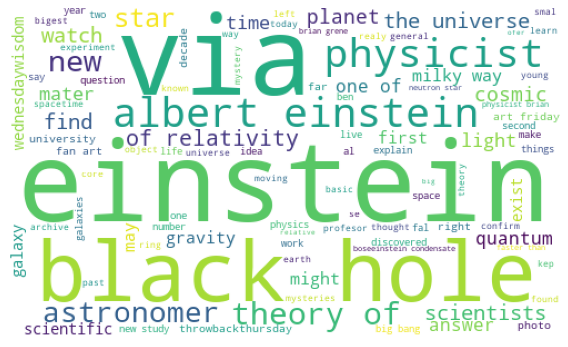

In [15]:
allWords = ''.join(i for i in df['Tweets'])
wordsCloud = WordCloud(max_font_size=100, max_words=100, width=500, height=300, background_color = 'white').generate(allWords)

plt.figure(figsize=(8,8))
plt.imshow(wordsCloud)
plt.axis("off")
plt.tight_layout()
plt.show()

> Dari gambar di atas, dapat dilihat kontribusi-kontribusi Einstein di dunia fisika, seperti misalnya relativitas umum dan lubang hitam. Terlihat juga ada kata Hawking dan Brian Greene di atas, dua fisikawan yang saya sangat kagumi. Menarik bisa melihat ada kata 'confirm' di atas, mungkin ini berhubungan dengan penemuan beberapa tahun yang lalu tentang gelombang gravitasi. 

In [16]:
def subjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def polarity(txt):
    return TextBlob(txt).sentiment.polarity

In [17]:
df['Subjectivity'] = df['Tweets'].apply(subjectivity)
df['Polarity'] = df['Tweets'].apply(polarity)

In [18]:
df.head()

,Tweets,split,Subjectivity,Polarity
0,the scientific mysteries that led to einstein’...,"[scientific, mysteries, led, einstein’s, emc2,...",0.000000,0.000000
1,birthed in the first second after the big bang...,"[birthed, first, second, big, bang, primordial...",0.348333,0.116667
2,wednesdaywisdom in the past it never ocured to...,"[wednesdaywisdom, past, never, ocured, every, ...",0.538889,-0.250000
3,einstein credited his acomplishments to his un...,"[einstein, credited, acomplishments, unbridled...",0.000000,0.000000
4,inteligence is relative 😎,"[inteligence, relative, 😎]",0.000000,0.000000


In [19]:
def sentiment(x):
    if x > 0:
        return 'positive'
    elif x < 0:
        return 'negative'
    else:
        return 'neutral'

In [20]:
df['sentiment'] = df['Polarity'].apply(sentiment)

In [21]:
df.head()

,Tweets,split,Subjectivity,Polarity,sentiment
0,the scientific mysteries that led to einstein’...,"[scientific, mysteries, led, einstein’s, emc2,...",0.000000,0.000000,neutral
1,birthed in the first second after the big bang...,"[birthed, first, second, big, bang, primordial...",0.348333,0.116667,positive
2,wednesdaywisdom in the past it never ocured to...,"[wednesdaywisdom, past, never, ocured, every, ...",0.538889,-0.250000,negative
3,einstein credited his acomplishments to his un...,"[einstein, credited, acomplishments, unbridled...",0.000000,0.000000,neutral
4,inteligence is relative 😎,"[inteligence, relative, 😎]",0.000000,0.000000,neutral


neutral     85
positive    81
negative    34
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Sentiment')

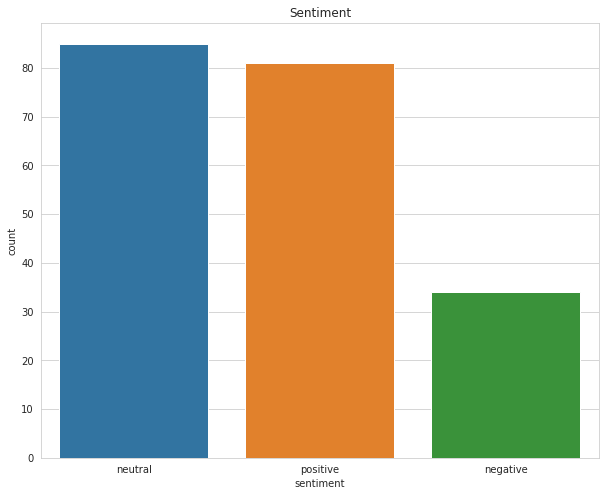

In [22]:
plt.figure(figsize = (10,8))
print(df['sentiment'].value_counts())
sns.countplot(df['sentiment'])
plt.title('Sentiment')

> Menarik melihat kebanyakan tweet-tweet di dataset ini positive untuk kata `AlbertEinstein`

# Modeling

## Dataset Splitting

In [23]:
X = df['Tweets']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(160,) (40,) (160,) (40,)


Saya akan menggunakan MultinominalNaiveBayes dalam melakukan modeling

In [24]:
paramsNB = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'nb__alpha': [1, 1e-1]
}

In [25]:
stop_words = set(stopwords.words('english'))

In [26]:
model = Pipeline([
    ('vect', CountVectorizer(stop_words = stop_words)),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB())
])

In [27]:
model_tuned = GridSearchCV(model, paramsNB, cv=3, scoring = 'f1_macro')
model_tuned.fit(X_train, y_train)

print(model_tuned.best_params_)

{'nb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}


In [28]:
print(classification_report(y_test, model_tuned.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

    negative       1.00      0.30      0.46        10
     neutral       0.71      0.86      0.77        14
    positive       0.60      0.75      0.67        16

    accuracy                           0.68        40
   macro avg       0.77      0.64      0.63        40
weighted avg       0.74      0.68      0.65        40



> Seharusnya model bisa lebih baik lagi.

# Sanity Check

In [29]:
model_tuned.best_estimator_.predict(['Albert Einstein is considered the greatest scientist'])

array(['positive'], dtype='<U8')

> Saya rasa model ini masih jauh dari sempurna. Namun ini bisa menjadi gambaran cara untuk melakukan sentiment analysis menggunakan tweet-tweet di twitter.